# Importação das bibliotecas

In [36]:
import matplotlib.pyplot as plt
plt.style.use('classic')
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from xgboost import XGBClassifier

import os

In [37]:
os.mkdir('/content/results')

# Importação do dataset

In [38]:
tabela = pd.read_csv('/content/drive/MyDrive/Projeto de Pesquisa/Artigo - Um Estudo sobre o Uso de Modelos de Machine Learning para Manutenção Preditiva Industrial/dataset/predictive_maintenance.csv')
tabela.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [39]:
tabela.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


In [40]:
tabela['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

# Proposta

## Pré-processamento

In [41]:
tabela['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: Failure Type, dtype: int64

In [42]:
falhas_aleatorias = tabela[tabela['Failure Type'] == 'Random Failures'].index
falha_de_desgaste_de_ferramenta = tabela[tabela['Failure Type'] == 'Tool Wear Failure'].index

tabela = tabela.drop(falhas_aleatorias, axis=0)
tabela = tabela.drop(falha_de_desgaste_de_ferramenta, axis=0)

tabela['Failure Type'].value_counts()

No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Name: Failure Type, dtype: int64

In [43]:
# Remoção de colunas desnecessárias
colunas = ['UDI', 'Product ID', 'Failure Type']
tabela = tabela.drop(colunas, axis=1)
tabela.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


In [44]:
# Alterando o tipo da coluna Type de categórico para numérico
type_columns_converting = pd.get_dummies(data=tabela['Type'])

tabela = tabela.assign(H=type_columns_converting['H'],
                             L=type_columns_converting['L'],
                             M=type_columns_converting['M'])

tabela = tabela[['H', 'L', 'M',
                 'Air temperature [K]',
                 'Process temperature [K]',
                 'Rotational speed [rpm]',
                 'Torque [Nm]',
                 'Tool wear [min]',
                 'Target']]

tabela.columns = ['H', 'L', 'M',
                  'Air Temperature',
                  'Process Temperature',
                  'Rotational Speed',
                  'Torque',
                  'Tool Wear',
                  'Target']

tabela.head()

,H,L,M,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target
0,0,0,1,298.1,308.6,1551,42.8,0,0
1,0,1,0,298.2,308.7,1408,46.3,3,0
2,0,1,0,298.1,308.5,1498,49.4,5,0
3,0,1,0,298.2,308.6,1433,39.5,7,0
4,0,1,0,298.2,308.7,1408,40.0,9,0


In [45]:
tabela.describe()

,H,L,M,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear,Target
count,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000
mean,0.099930,0.600081,0.299990,300.002264,310.003482,1538.721043,39.993006,107.437557,0.029586
std,0.299921,0.489906,0.458276,2.000662,1.483394,179.245643,9.967446,63.363141,0.169452
min,0.000000,0.000000,0.000000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,0.000000,1.000000,0.000000,300.100000,310.100000,1503.000000,40.100000,107.000000,0.000000
75%,0.000000,1.000000,1.000000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,1.000000,1.000000,1.000000,304.500000,313.800000,2886.000000,76.600000,251.000000,1.000000


In [46]:
x = tabela.drop('Target', axis=1)
y = tabela['Target']

In [47]:
escalador = MinMaxScaler()
x = escalador.fit_transform(x)
x = pd.DataFrame(data=x, columns=['H', 'L', 'M',
                  'Air Temperature',
                  'Process Temperature',
                  'Rotational Speed',
                  'Torque',
                  'Tool Wear',])
x.describe()

,H,L,M,Air Temperature,Process Temperature,Rotational Speed,Torque,Tool Wear
count,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000,9937.000000
mean,0.099930,0.600081,0.299990,0.511116,0.531294,0.215786,0.497157,0.428038
std,0.299921,0.489906,0.458276,0.217463,0.183135,0.104334,0.136915,0.252443
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.326087,0.382716,0.148428,0.403846,0.211155
50%,0.000000,1.000000,0.000000,0.521739,0.543210,0.194994,0.498626,0.426295
75%,0.000000,1.000000,1.000000,0.673913,0.666667,0.258440,0.590659,0.645418
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


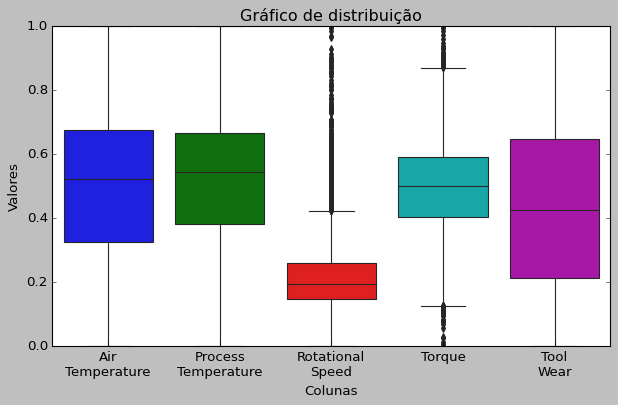

In [48]:
x_boxplot = x[['Air Temperature', 'Process Temperature', 'Rotational Speed', 'Torque', 'Tool Wear']]
x_boxplot.columns = ['Air\nTemperature', 'Process\nTemperature', 'Rotational\nSpeed', 'Torque', 'Tool\nWear']
boxplot = sns.boxplot(data=x_boxplot[['Air\nTemperature', 'Process\nTemperature', 'Rotational\nSpeed', 'Torque', 'Tool\nWear']]);
boxplot.figure.set_size_inches(9, 5)
plt.title('Gráfico de distribuição')
plt.xlabel('Colunas')
plt.ylabel('Valores')
plt.savefig('Boxplot.png')

## Separação dos subconjuntos de treino, teste e validação

In [49]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, random_state=42, stratify=y, train_size=0.80)
x_teste, x_validacao, y_teste, y_validacao = train_test_split(x_teste, y_teste, random_state=42, stratify=y_teste, train_size=0.5)

In [50]:
print('Tamanho dos conjuntos')
print('Conjunto\tQtd. Linhas\tQtd. Colunas')
print(f'X Treino\t{x_treino.shape[0]}\t\t{x_treino.shape[1]}')
print(f'Y Treino\t{y_treino.shape[0]}\t\t1')
print(f'X Teste\t\t{x_teste.shape[0]}\t\t{x_teste.shape[1]}')
print(f'Y Teste\t\t{y_teste.shape[0]}\t\t1')
print(f'X Validação\t{x_validacao.shape[0]}\t\t{x_validacao.shape[1]}')
print(f'Y Validação\t{y_validacao.shape[0]}\t\t1')

Tamanho dos conjuntos
Conjunto	Qtd. Linhas	Qtd. Colunas
X Treino	7949		8
Y Treino	7949		1
X Teste		994		8
Y Teste		994		1
X Validação	994		8
Y Validação	994		1


## Aplicação dos modelos

### Árvore de Decisão

In [51]:
parametros_arvore_decisao = {
   'max_depth': np.arange(1, 20) 
}

grid_search_arvore_decisao = GridSearchCV(DecisionTreeClassifier(), parametros_arvore_decisao, cv=5, scoring='recall')
grid_search_arvore_decisao.fit(x_treino, y_treino)
melhores_parametros_arvore_decisao = grid_search_arvore_decisao.best_params_
melhores_parametros_arvore_decisao

{'max_depth': 10}

In [52]:
clf_tree = DecisionTreeClassifier(max_depth=2)
validacao_cruzada_arvore_decisao = cross_validate(estimator=clf_tree, X=x_validacao, y=y_validacao, cv=5, return_train_score=True)
validacao_cruzada_arvore_decisao

{'fit_time': array([0.00726318, 0.00745678, 0.00846171, 0.00649071, 0.00554919]),
 'score_time': array([0.02279091, 0.00316978, 0.00338459, 0.00408411, 0.00913477]),
 'test_score': array([0.98492462, 0.9798995 , 0.96984925, 0.98994975, 0.97474747]),
 'train_score': array([0.97987421, 0.98113208, 0.9836478 , 0.97861635, 0.98241206])}

In [91]:
print(validacao_cruzada_arvore_decisao['train_score'].mean()* 100)
print(validacao_cruzada_arvore_decisao['test_score'].mean()* 100)

98.11365001106161
97.9874118065073


In [53]:
clf_tree.fit(x_treino, y_treino)
predicao = clf_tree.predict(x_teste)

In [54]:
resultados = classification_report(y_teste, predicao, digits=3) 
print(resultados)

acuracia_arvore_decisao = clf_tree.score(x_teste, y_teste) * 100
precisao_arvore_decisao = precision_score(y_teste, predicao, average="weighted") * 100
revocacao_arvore_decisao = recall_score(y_teste, predicao, average="weighted") * 100
f1_arvore_decisao = f1_score(y_teste, predicao, average="weighted") * 100
print(f'Acurácia: {acuracia_arvore_decisao:.3f}')
print(f'Precisão Média: {precisao_arvore_decisao:.3f}')
print(f'Revocação Média: {revocacao_arvore_decisao:.3f}')
print(f'F1 Média: {f1_arvore_decisao:.3f}')

              precision    recall  f1-score   support

           0      0.978     0.999     0.988       964
           1      0.889     0.267     0.410        30

    accuracy                          0.977       994
   macro avg      0.933     0.633     0.699       994
weighted avg      0.975     0.977     0.971       994

Acurácia: 97.686
Precisão Média: 97.499
Revocação Média: 97.686
F1 Média: 97.076


In [55]:
export_graphviz(clf_tree, out_file='outfile.dot', feature_names=x_teste.columns)

In [56]:
!dot -Tpng outfile.dot -o /content/results/arvore.png

### Teorema de Bayes

In [57]:
clf_bayes = GaussianNB()

In [58]:
validacao_cruzada_naive_bayes = cross_validate(estimator=clf_tree, X=x_validacao, y=y_validacao, return_train_score=True)
validacao_cruzada_naive_bayes

{'fit_time': array([0.01141953, 0.00479054, 0.01209641, 0.00421929, 0.00422025]),
 'score_time': array([0.00301433, 0.02360582, 0.00276542, 0.00239086, 0.00249052]),
 'test_score': array([0.98492462, 0.97487437, 0.96984925, 0.98994975, 0.97474747]),
 'train_score': array([0.97987421, 0.98113208, 0.9836478 , 0.97861635, 0.98241206])}

In [90]:
print(validacao_cruzada_naive_bayes['train_score'].mean()* 100)
print(validacao_cruzada_naive_bayes['test_score'].mean()* 100)

98.11365001106161
97.88690929394447


In [59]:
clf_bayes.fit(x_treino, y_treino)
predicao_naive_bayes = clf_bayes.predict(x_teste)

In [60]:
print(classification_report(y_teste, predicao_naive_bayes, digits=3))

acuracia_naive_bayes = clf_bayes.score(x_teste, y_teste) * 100
precisao_naive_bayes = precision_score(y_teste, predicao_naive_bayes, average="weighted") * 100
revocacao_naive_bayes = recall_score(y_teste, predicao_naive_bayes, average="weighted") * 100
f1_naive_bayes = f1_score(y_teste, predicao_naive_bayes, average="weighted") * 100
print(f'Acurácia: {acuracia_naive_bayes:.2f}')
print(f'Precisão Média: {precisao_naive_bayes:.2f}')
print(f'Revocação Média: {revocacao_naive_bayes:.2f}')
print(f'F1 Média: {f1_naive_bayes:.2f}')

              precision    recall  f1-score   support

           0      0.973     0.985     0.979       964
           1      0.222     0.133     0.167        30

    accuracy                          0.960       994
   macro avg      0.598     0.559     0.573       994
weighted avg      0.951     0.960     0.955       994

Acurácia: 95.98
Precisão Média: 95.07
Revocação Média: 95.98
F1 Média: 95.49


### SVM

In [61]:
clf_svm = SVC(C=100, kernel='rbf', gamma='scale')
validacao_cruzada_svm = cross_validate(estimator=clf_svm, X=x_validacao, y=y_validacao, return_train_score=True)
validacao_cruzada_svm

{'fit_time': array([0.03638411, 0.01513124, 0.01437879, 0.03016949, 0.02376628]),
 'score_time': array([0.01185083, 0.00432754, 0.00438857, 0.00447035, 0.00448751]),
 'test_score': array([0.98492462, 0.95979899, 0.97487437, 0.97487437, 0.96969697]),
 'train_score': array([0.98490566, 0.98993711, 0.98993711, 0.98993711, 0.99246231])}

In [89]:
print(validacao_cruzada_svm['train_score'].mean()* 100)
print(validacao_cruzada_svm['test_score'].mean()* 100)

98.94358585379729
97.2833866301203


In [62]:
clf_svm.fit(x_treino, y_treino)
predicao_svm = clf_svm.predict(x_teste)

In [63]:
print(classification_report(y_teste, predicao, digits=3))

acuracia_svm = clf_svm.score(x_teste, y_teste) * 100
precisao_svm = precision_score(y_teste, predicao_svm, average="weighted") * 100
revocacao_svm = recall_score(y_teste, predicao_svm, average="weighted") * 100
f1_svm = f1_score(y_teste, predicao, average="weighted") * 100
print(f'Acurácia: {acuracia_svm:.3f}')
print(f'Precisão Média: {precisao_svm:.3f}')
print(f'Revocação Média: {revocacao_svm:.3f}')
print(f'F1 Média: {f1_svm:.3f}')

              precision    recall  f1-score   support

           0      0.978     0.999     0.988       964
           1      0.889     0.267     0.410        30

    accuracy                          0.977       994
   macro avg      0.933     0.633     0.699       994
weighted avg      0.975     0.977     0.971       994

Acurácia: 98.390
Precisão Média: 98.254
Revocação Média: 98.390
F1 Média: 97.076


### XGBoost

In [64]:
parametros_xgb = {
    'booster': ['dart', 'gbtree'],
    'tree_method': ['auto', 'approx', 'hist', 'exact'],
    'eta': np.arange(0.1, 0.205, 0.05),
    'gamma': np.arange(0, 101),
    'max_depth': np.arange(3, 12),
    'objective': ['binary:hinge'],
    'eval_metric': ['error', 'auc', 'aucpr']
}

randomized_search_xgb = RandomizedSearchCV(estimator=XGBClassifier(),
                                           param_distributions=parametros_xgb,
                                           n_iter=10,
                                           scoring='accuracy',
                                           cv=5,
                                           return_train_score=True)

randomized_search_xgb.fit(x_treino, y_treino)
melhores_parametros_xgb = randomized_search_xgb.best_params_
melhores_parametros_xgb

{'tree_method': 'auto',
 'objective': 'binary:hinge',
 'max_depth': 7,
 'gamma': 3,
 'eval_metric': 'auc',
 'eta': 0.15000000000000002,
 'booster': 'gbtree'}

In [65]:
randomized_search_xgb.cv_results_['mean_test_score']

array([0.98125557, 0.97043653, 0.97207238, 0.97182057, 0.9899356 ,
       0.971569  , 0.97043653, 0.97962066, 0.96943064, 0.971569  ])

In [66]:
randomized_search_xgb.cv_results_['mean_train_score']

array([0.98603611, 0.97043653, 0.97578308, 0.97288962, 0.99962259,
       0.9725122 , 0.97043653, 0.98345699, 0.97200897, 0.9725122 ])

In [67]:
clf_xgb = XGBClassifier(booster='dart',
                        max_depth=4,
                        objective='binary:hinge',
                        eval_metric='error',
                        eta=0.15)
validacao_cruzada = cross_validate(estimator=clf_xgb, X=x_treino, y=y_treino, cv=5, return_train_score=True)
validacao_cruzada

{'fit_time': array([2.3354032 , 1.92081261, 1.49720097, 1.45197415, 1.47822833]),
 'score_time': array([0.01234102, 0.00886869, 0.00847006, 0.01053524, 0.00874329]),
 'test_score': array([0.98930818, 0.98993711, 0.99056604, 0.98867925, 0.98678414]),
 'train_score': array([0.99905646, 0.99905646, 0.99858468, 0.99937097, 0.99937107])}

In [88]:
print(validacao_cruzada['train_score'].mean()* 100)
print(validacao_cruzada['test_score'].mean()* 100)

99.90879266844101
98.90549414013798


In [68]:
clf_xgb.fit(x_treino, y_treino)

XGBClassifier(booster='dart', eta=0.15, eval_metric='error', max_depth=4,
              objective='binary:hinge')

In [69]:
predicao_xgb = clf_xgb.predict(x_teste)
print(classification_report(y_teste, predicao, digits=3))

acuracia_xgb = clf_xgb.score(x_teste, y_teste) * 100
precisao_xgb = precision_score(y_teste, predicao_xgb, average='weighted') * 100
revocacao_xgb = recall_score(y_teste, predicao_xgb, average='weighted') * 100
f1_xgb = f1_score(y_teste, predicao_xgb, average='weighted') * 100
print(f'Acurácia: {acuracia_xgb:.3f}')
print(f'Precisão Média: {precisao_xgb:.3f}')
print(f'Revocação Média: {revocacao_xgb:.3f}')
print(f'F1 Média: {f1_xgb:.3f}')

              precision    recall  f1-score   support

           0      0.978     0.999     0.988       964
           1      0.889     0.267     0.410        30

    accuracy                          0.977       994
   macro avg      0.933     0.633     0.699       994
weighted avg      0.975     0.977     0.971       994

Acurácia: 99.195
Precisão Média: 99.226
Revocação Média: 99.195
F1 Média: 99.208


### Rede Neural Artificial (ANN)

In [70]:
layer_sizes = []
for i in range(1, 20):
  size = (i,)
  layer_sizes.append(size)

In [71]:
mlp_params = {
  'hidden_layer_sizes': layer_sizes,
  'activation': ['identity', 'logistic', 'tanh', 'relu'],
  'solver': ['sgd', 'adam'],
  'learning_rate': ['constant', 'invscaling', 'adaptive'], # Only solver is sgd
  'random_state': [0],
  'validation_fraction': [0.1, 0.2, 0.3],
  'max_iter': [200]
}

randomized_search_mlp = RandomizedSearchCV(estimator=MLPClassifier(), param_distributions=mlp_params,
                                           n_iter=10, scoring='accuracy', cv=5,
                                           return_train_score=True)
randomized_search_mlp.fit(x_treino, y_treino)
melhores_parametros_mlp = randomized_search_mlp.best_params_
melhores_parametros_mlp

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

{'validation_fraction': 0.1,
 'solver': 'adam',
 'random_state': 0,
 'max_iter': 200,
 'learning_rate': 'invscaling',
 'hidden_layer_sizes': (17,),
 'activation': 'tanh'}

In [72]:
randomized_search_mlp.cv_results_['mean_train_score']

array([0.97043653, 0.97043653, 0.97043653, 0.97043653, 0.97043653,
       0.97122279, 0.97402189, 0.97043653, 0.97043653, 0.97408478])

In [73]:
randomized_search_mlp.cv_results_['mean_test_score']

array([0.97043653, 0.97043653, 0.97043653, 0.97043653, 0.97043653,
       0.97081389, 0.97383323, 0.97043653, 0.97043653, 0.97358142])

In [74]:
mlp = MLPClassifier(hidden_layer_sizes=melhores_parametros_mlp['hidden_layer_sizes'],
                    solver=melhores_parametros_mlp['solver'], 
                    random_state=melhores_parametros_mlp['random_state'],
                    max_iter=melhores_parametros_mlp['max_iter'],
                    learning_rate=melhores_parametros_mlp['learning_rate'],
                    activation=melhores_parametros_mlp['activation'],
                    validation_fraction=melhores_parametros_mlp['validation_fraction'])

In [75]:
validacao_cruzada_mlp = cross_validate(estimator=mlp, X=x_treino, y=y_treino, cv=5, return_train_score=True)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multi

In [76]:
validacao_cruzada_mlp

{'fit_time': array([7.62446404, 5.45691276, 3.51274514, 3.46806216, 4.64581037]),
 'score_time': array([0.00380039, 0.00369048, 0.0043323 , 0.01508689, 0.0046742 ]),
 'test_score': array([0.97358491, 0.97295597, 0.97295597, 0.9754717 , 0.97419761]),
 'train_score': array([0.97405252, 0.9745243 , 0.97420978, 0.97342349, 0.97389937])}

In [87]:
print(validacao_cruzada_mlp['train_score'].mean()* 100)
print(validacao_cruzada_mlp['test_score'].mean()* 100)

97.4021893399243
97.38332324035923


In [77]:
mlp.fit(x_treino, y_treino)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(activation='tanh', hidden_layer_sizes=(17,),
              learning_rate='invscaling', random_state=0)

In [78]:
predicao_mlp = mlp.predict(x_teste)
print(classification_report(y_teste, predicao_mlp, digits=3))

acuracia_mlp = mlp.score(x_teste, y_teste) * 100
precisao_mlp = precision_score(y_teste, predicao_mlp, average='weighted') * 100
revocacao_mlp = recall_score(y_teste, predicao_mlp, average='weighted') * 100
f1_mlp = f1_score(y_teste, predicao_mlp, average='weighted') * 100
print(f'Acurácia: {acuracia_mlp:.3f}')
print(f'Precisão Média: {precisao_mlp:.3f}')
print(f'Revocação Média: {revocacao_mlp:.3f}')
print(f'F1 Média: {f1_mlp:.3f}')

              precision    recall  f1-score   support

           0      0.977     0.998     0.987       964
           1      0.778     0.233     0.359        30

    accuracy                          0.975       994
   macro avg      0.877     0.616     0.673       994
weighted avg      0.971     0.975     0.968       994

Acurácia: 97.485
Precisão Média: 97.065
Revocação Média: 97.485
F1 Média: 96.821


# Resultados

## Acurácia

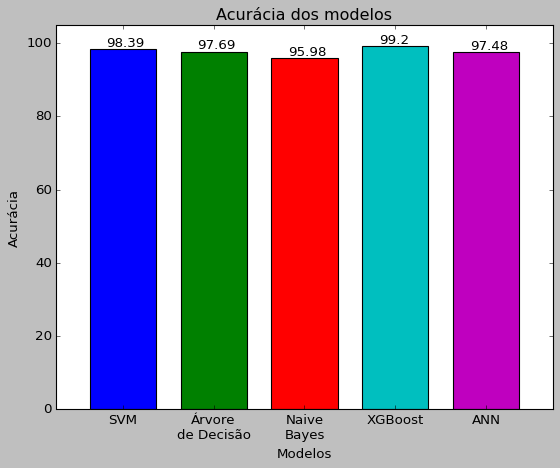

In [79]:
modelos = ['SVM', 'Árvore\nde Decisão', 'Naive\nBayes', 'XGBoost', 'ANN']
figure_acuracia, ax_acuracia = plt.subplots()
plt.title('Acurácia dos modelos')
ax_acuracia.bar(2.8, acuracia_svm, label='SVM')
plt.text(2.6, acuracia_svm + 0.8, round(acuracia_svm, 2))
ax_acuracia.bar(3.9, acuracia_arvore_decisao, label='Árvore de Decisão')
plt.text(3.7, acuracia_arvore_decisao + 0.8, round(acuracia_arvore_decisao, 2))
ax_acuracia.bar(5, acuracia_naive_bayes, label='Naive Bayes')
plt.text(4.8, acuracia_naive_bayes + 0.8, round(acuracia_naive_bayes, 2))
ax_acuracia.bar(6.1, acuracia_xgb, label='XGBoost')
plt.text(5.9, acuracia_xgb + 0.8, round(acuracia_xgb, 2))
ax_acuracia.bar(7.2, acuracia_mlp, label='ANN')
plt.text(7, acuracia_mlp + 0.8, round(acuracia_mlp, 2))
plt.xticks([2.8, 3.9, 5, 6.1, 7.2], modelos)
plt.xlabel('Modelos')
ax_acuracia.set_ylabel('Acurácia')
ax_acuracia.set_ylim([0, 105])
#plt.legend(bbox_to_anchor = (0.72, -0.15))
#plt.legend(loc='lower right')

plt.savefig('/content/results/Resultados-Acurácia.png')

plt.show();

## Precisão

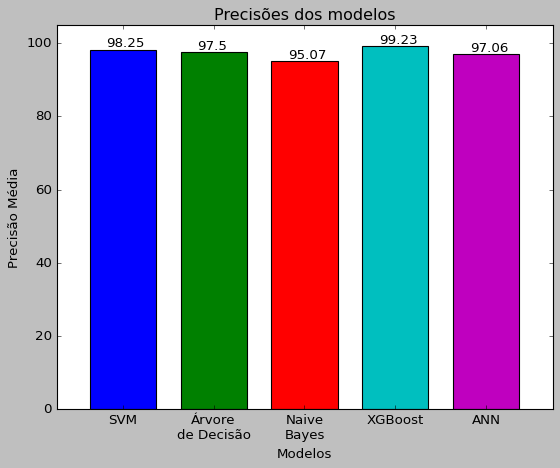

In [80]:
figure_precisao, ax_precisao = plt.subplots()
plt.title('Precisões dos modelos')
ax_precisao.bar(2.8, precisao_svm, label='SVM')
plt.text(2.6, precisao_svm + 0.8, round(precisao_svm, 2))
ax_precisao.bar(3.9, precisao_arvore_decisao, label='Árvore de Decisão')
plt.text(3.7, precisao_arvore_decisao + 0.8, round(precisao_arvore_decisao, 2))
ax_precisao.bar(5, precisao_naive_bayes, label='Naive Bayes')
plt.text(4.8, precisao_naive_bayes + 0.8, round(precisao_naive_bayes, 2))
ax_precisao.bar(6.1, precisao_xgb, label='XGBoost')
plt.text(5.9, precisao_xgb + 0.8, round(precisao_xgb, 2))
ax_precisao.bar(7.2, precisao_mlp, label='ANN')
plt.text(7, precisao_mlp + 0.8, round(precisao_mlp, 2))
plt.xticks([2.8, 3.9, 5, 6.1, 7.2], modelos)
ax_precisao.set_xlabel('Modelos')
ax_precisao.set_ylabel('Precisão Média')
ax_precisao.set_ylim([0, 105])
#plt.legend(loc='lower right')

plt.savefig('/content/results/Resultados-Precisão.png')

plt.show()

## Revocação

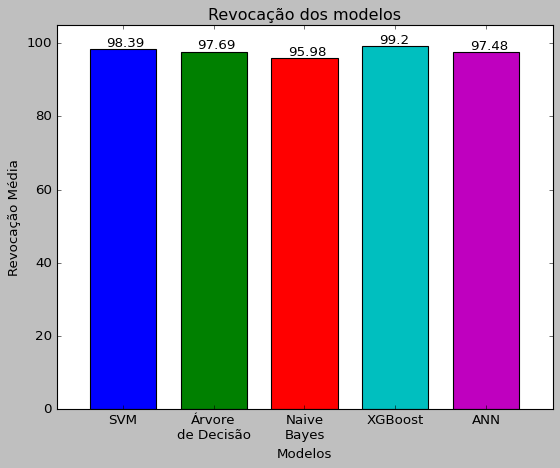

In [81]:
figure_revocacao, ax_revocacao = plt.subplots()
plt.title('Revocação dos modelos')
ax_revocacao.bar(2.8, revocacao_svm, label='SVM')
plt.text(2.6, revocacao_svm + 0.8, round(revocacao_svm, 2))
ax_revocacao.bar(3.9, revocacao_arvore_decisao, label='Árvore de Decisão')
plt.text(3.7, revocacao_arvore_decisao + 0.8, round(revocacao_arvore_decisao, 2))
ax_revocacao.bar(5, revocacao_naive_bayes, label='Naive Bayes')
plt.text(4.8, revocacao_naive_bayes + 0.8, round(revocacao_naive_bayes, 2))
ax_revocacao.bar(6.1, revocacao_xgb, label='XGBoost')
plt.text(5.9, revocacao_xgb + 0.8, round(revocacao_xgb, 2))
ax_revocacao.bar(7.2, revocacao_mlp, label='ANN')
plt.text(7, revocacao_mlp + 0.8, round(revocacao_mlp, 2))
plt.xticks([2.8, 3.9, 5, 6.1, 7.2], modelos)
ax_revocacao.set_xlabel('Modelos')
ax_revocacao.set_ylabel('Revocação Média')
ax_revocacao.set_ylim([0, 105])
#plt.legend(loc='lower right')

plt.savefig('/content/results/Resultados-Revocação.png')

plt.show()

### F1

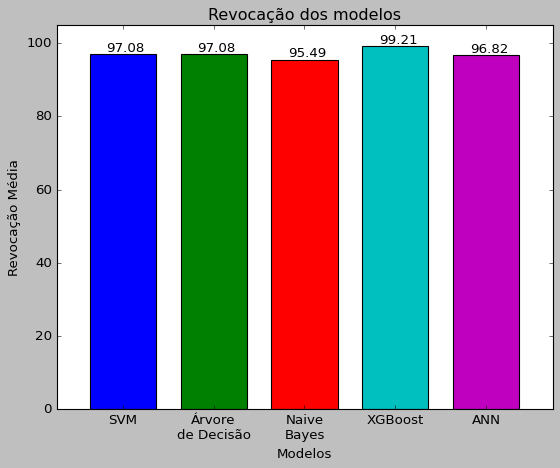

In [82]:
figure_f1, ax_f1 = plt.subplots()
plt.title('Revocação dos modelos')
ax_f1.bar(2.8, f1_svm, label='SVM')
plt.text(2.6, f1_svm + 0.8, round(f1_svm, 2))
ax_f1.bar(3.9, f1_arvore_decisao, label='Árvore de Decisão')
plt.text(3.7, f1_arvore_decisao + 0.8, round(f1_arvore_decisao, 2))
ax_f1.bar(5, f1_naive_bayes, label='Naive Bayes')
plt.text(4.8, f1_naive_bayes + 0.8, round(f1_naive_bayes, 2))
ax_f1.bar(6.1, f1_xgb, label='XGBoost')
plt.text(5.9, f1_xgb + 0.8, round(f1_xgb, 2))
ax_f1.bar(7.2, f1_mlp, label='ANN')
plt.text(7, f1_mlp + 0.8, round(f1_mlp, 2))
plt.xticks([2.8, 3.9, 5, 6.1, 7.2], modelos)
ax_f1.set_xlabel('Modelos')
ax_f1.set_ylabel('Revocação Média')
ax_f1.set_ylim([0, 105])
#plt.legend(loc='lower right')

plt.savefig('/content/results/Resultados-F1.png')

plt.show()

## Tempo de Treinamento

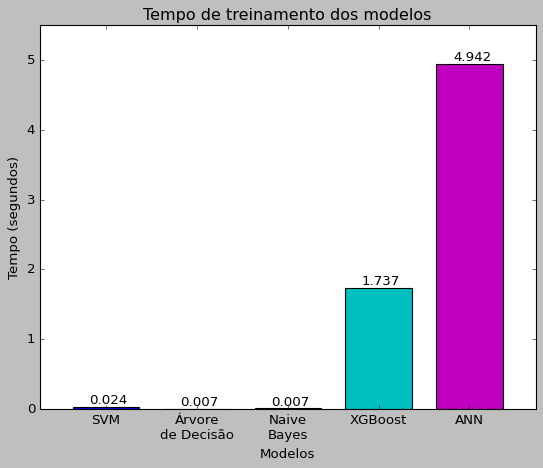

In [84]:
figure_tempo, ax_tempo = plt.subplots()
plt.title('Tempo de treinamento dos modelos')
ax_tempo.bar(2.8, validacao_cruzada_svm['fit_time'].mean(), label='SVM')
plt.text(2.6, validacao_cruzada_svm['fit_time'].mean() + 0.05, round(validacao_cruzada_svm['fit_time'].mean(), 4))
ax_tempo.bar(3.9, validacao_cruzada_arvore_decisao['fit_time'].mean(), label='Árvore de Decisão')
plt.text(3.7, validacao_cruzada_arvore_decisao['fit_time'].mean() + 0.05, round(validacao_cruzada_arvore_decisao['fit_time'].mean(), 3))
ax_tempo.bar(5, validacao_cruzada_naive_bayes['fit_time'].mean(), label='Naive Bayes')
plt.text(4.8, validacao_cruzada_naive_bayes['fit_time'].mean() + 0.05, round(validacao_cruzada_naive_bayes['fit_time'].mean(), 3))
ax_tempo.bar(6.1, validacao_cruzada['fit_time'].mean(), label='XGBoost')
plt.text(5.9, validacao_cruzada['fit_time'].mean() + 0.05, round(validacao_cruzada['fit_time'].mean(), 3))
ax_tempo.bar(7.2, validacao_cruzada_mlp['fit_time'].mean(), label='ANN')
plt.text(7, validacao_cruzada_mlp['fit_time'].mean() + 0.05, round(validacao_cruzada_mlp['fit_time'].mean(), 3))
plt.xticks([2.8, 3.9, 5, 6.1, 7.2], modelos)
ax_tempo.set_xlabel('Modelos')
ax_tempo.set_ylabel('Tempo (segundos)')
ax_tempo.set_ylim([0, 5.5])
#plt.legend(loc='upper left')

plt.savefig('/content/results/Resultados-TempoDeTreinamento.png')

plt.show()